# WEAKLY SUPERVISED LOCALIZATION 
## WITH RETINA DATASET

In [1]:
import os
import numpy as np
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# SPECIFY WHICH GPU TO USE

In [2]:
device_type = "/gpu:1"

# DEFINE FUNCTIONS

In [3]:
def imread(path):
    img = scipy.misc.imread(path).astype(np.float)
    if len(img.shape) == 2:
        img = np.transpose(np.array([img, img, img]), (2, 0, 1))
    return img
def imsave(path, img):
    img = np.clip(img, 0, 255).astype(np.uint8)
    scipy.misc.imsave(path, img)
def print_np(x, s):
    print ("Type of '%s' is %s" % (s, type(x)))
    print ("Shape of '%s' is %s" % (s, x.shape,))

# LOAD CALTECH 101 DATA

In [4]:
cwd = os.getcwd()
path = cwd + "/../../retina_dataset/dataset"
valid_exts = [".jpg", ".gif", ".png", ".jpeg"]
print ("[%d] CATEGORIES ARE IN \n %s" % (len(os.listdir(path)), path))

categories = sorted(os.listdir(path))
ncategories = len(categories)
imgs = []
labels = []
# LOAD ALL IMAGES 
for i, category in enumerate(categories):
    for f in os.listdir(path + "/" + category):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in valid_exts:
            continue
        fullpath = os.path.join(path + "/" + category, f)
        img = scipy.misc.imresize(imread(fullpath), [224, 224, 3])
        imgs.append(img) # NORMALIZE IMAGE 
        label_curr = np.zeros((ncategories))
        label_curr[i] = 1
        labels.append(label_curr)
print ("Num imgs: %d" % (len(imgs)))
print ("Num labels: %d" % (len(labels)) )

[4] CATEGORIES ARE IN 
 /home/enginius/github/tensorflow-101/notebooks/../../retina_dataset/dataset
Num imgs: 601
Num labels: 601


## DIVIDE THE DATASET INTO TWO

In [5]:
ndata = len(imgs)
ntrain = int(ndata*0.7) # WILL USE 70% FOR TRAINING
ntest = ndata-ntrain
randidx = np.random.permutation(ndata)
trainidx = randidx[:ntrain]
testidx = randidx[ntrain+1:]
train_imgs = [imgs[idx] for idx in trainidx]
train_labels = [labels[idx] for idx in trainidx]
test_imgs = [imgs[idx] for idx in testidx]
test_labels = [labels[idx] for idx in testidx]
# TENSORIZE DATA 
train_imgs_tensor = np.stack(train_imgs, axis=0)
train_labels_tensor = np.stack(train_labels, axis=0)
test_imgs_tensor = np.stack(test_imgs, axis=0)
test_labels_tensor = np.stack(test_labels, axis=0)
print "Num train_imgs: %d" % (len(train_imgs))
print "Num test_imgs: %d" % (len(test_imgs))
print_np(train_imgs_tensor, "train_imgs_tensor")
print_np(train_labels_tensor, "train_labels_tensor")
print_np(test_imgs_tensor, "test_imgs_tensor")
print_np(test_labels_tensor, "test_labels_tensor")
# REMOVE LISTS FROM MEMORY
del train_imgs, train_labels, test_imgs, test_labels

Num train_imgs: 420
Num test_imgs: 180
Type of 'train_imgs_tensor' is <type 'numpy.ndarray'>
Shape of 'train_imgs_tensor' is (420, 224, 224, 3)
Type of 'train_labels_tensor' is <type 'numpy.ndarray'>
Shape of 'train_labels_tensor' is (420, 4)
Type of 'test_imgs_tensor' is <type 'numpy.ndarray'>
Shape of 'test_imgs_tensor' is (180, 224, 224, 3)
Type of 'test_labels_tensor' is <type 'numpy.ndarray'>
Shape of 'test_labels_tensor' is (180, 4)


# PLOT DATASET

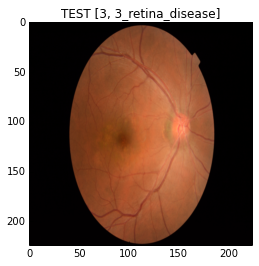

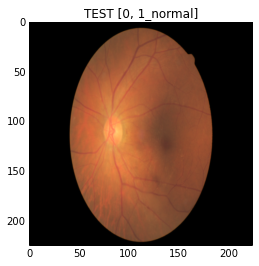

In [6]:
randidx = np.sort(np.random.randint(ntrain, size=2))-1
for i, j in enumerate(randidx):
    curr_img = train_imgs_tensor[j, :, :, :]
    curr_label = np.argmax(train_labels_tensor[j, :])
    plt.figure(i)
    plt.imshow(curr_img)
    plt.title("TRAIN [" + str(curr_label) + ", " + categories[curr_label] + "]")
    plt.draw()
randidx = np.sort(np.random.randint(ntest, size=2))-1
for i, j in enumerate(randidx):
    curr_img = test_imgs_tensor[j, :, :, :]
    curr_label = np.argmax(test_labels_tensor[j, :])
    plt.figure(i)
    plt.imshow(curr_img)
    plt.title("TEST [" + str(curr_label) + ", " + categories[curr_label] + "]")
    plt.draw()

# HELPER FUNCTIONS FOR USING VGG19

In [7]:
with tf.device(device_type):
    # FUNCTIONS FOR USING VGG19
    def conv_layer(input, weights, bias):
        conv = tf.nn.conv2d(input, tf.constant(weights), strides=[1, 1, 1, 1], padding='SAME')
        return tf.nn.bias_add(conv, bias)
    def pool_layer(input):
        return tf.nn.max_pool(input, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    def preprocess(image, mean_pixel):
        return image - mean_pixel
    print "Functions for VGG ready"

    # Define network
    def vggnet(data_path, input_image):
        layers = (
            'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',
            'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',
            'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
            'relu3_3', 'conv3_4', 'relu3_4', 'pool3',
            'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
            'relu4_3', 'conv4_4', 'relu4_4', 'pool4',
            'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
            'relu5_3', 'conv5_4', 'relu5_4'
        )
        data = scipy.io.loadmat(data_path) # Read .mat file via scipy.io.loadmat
        mean = data['normalization'][0][0][0]
        mean_pixel = np.mean(mean, axis=(0, 1))
        weights = data['layers'][0]
        net = {}
        current = preprocess(input_image, mean_pixel)
        for i, name in enumerate(layers):
            kind = name[:4]
            if kind == 'conv':
                kernels, bias = weights[i][0][0][0][0]
                # matconvnet: weights are [width, height, in_channels, out_channels]
                # tensorflow: weights are [height, width, in_channels, out_channels]
                kernels = np.transpose(kernels, (1, 0 , 2, 3))
                bias = bias.reshape(-1)
                current = conv_layer(current, kernels, bias)
            elif kind == 'relu':
                current = tf.nn.relu(current)
            elif kind == 'pool':
                current = pool_layer(current)
            net[name] = current
        assert len(net) == len(layers)
        return net, mean_pixel, layers
print ("Network for VGG ready")

Functions for VGG ready
Network for VGG ready


# LOAD PRETRAINED VGG19

In [8]:
cwd = os.getcwd()
VGG_PATH = cwd + "/data/imagenet-vgg-verydeep-19.mat"
img_placeholder = tf.placeholder('float', shape=(None, 224, 224, 3))
with tf.device(device_type):
    vgg, _, _ = vggnet(VGG_PATH, img_placeholder)    

# DEFINE GAP NETWORK

In [9]:
# PARAMETERS
n_output = ncategories
y = tf.placeholder('float', [None, n_output])
kr = tf.placeholder('float')
with tf.device(device_type):
    weights = {
        'wc': tf.Variable(tf.truncated_normal([3, 3, 512, 512], stddev=0.1)),
        'out': tf.Variable(tf.random_normal([512, n_output], stddev=0.1))
    }
    biases = {
        'bc': tf.Variable(tf.random_normal([512], stddev=0.1)),
        'out': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }
    # NETWORK
    def cam(_x, _W, _b, _kr):
        conv = tf.nn.conv2d(_x, _W['wc'], strides=[1, 1, 1, 1], padding='SAME')
        conv_relu = tf.nn.relu(tf.nn.bias_add(conv, _b['bc'])) 
        gap = tf.nn.avg_pool(conv_relu, ksize=[1, 14, 14, 1], strides=[1, 14, 14, 1],
                padding='SAME')
        gap_dr = tf.nn.dropout(gap, _kr)
        gap_vec = tf.reshape(gap_dr, [-1, _W['out'].get_shape().as_list()[0]])
        out = tf.add(tf.matmul(gap_vec, _W['out']), _b['out'])
        ret = {'gap': gap, 'gap_dr': gap_dr, 'gap_vec': gap_vec, 'out': out}
        return ret
print ("NETWORK READY")

NETWORK READY


# DEFINE FUNCTIONS FOR THE NETWORK

In [10]:
with tf.device(device_type):
    pred = cam(vgg['relu5_4'], weights, biases, kr)['out']
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
    optm = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)
    corr = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accr = tf.reduce_mean(tf.cast(corr, 'float'))
    init = tf.initialize_all_variables()
print ("FUNCTIONS READY")

FUNCTIONS READY


# TRAIN THE NETWRORK

In [11]:
# SOME PARAMETERS
training_epochs = 200
batch_size = 128
total_batch = (ntrain // batch_size) + 1
disp_step = 5

sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))
sess.run(init)
for epoch in range(training_epochs):
    avg_cost = 0.
    for i in range(total_batch):
        randidx = np.random.randint(ntrain, size=batch_size)
        batch_x = train_imgs_tensor[randidx, :, :, :]
        batch_y = train_labels_tensor[randidx, :]
        feeds_iter = {img_placeholder: batch_x, y: batch_y, kr: 0.7}
        _, c = sess.run([optm, cost], feed_dict=feeds_iter)
        featmap = sess.run(vgg['relu5_4'], feed_dict={img_placeholder: batch_x})
        avg_cost += c 
    avg_cost = avg_cost / total_batch
    if epoch % disp_step == 0:
        feeds_train = {img_placeholder: batch_x, y: batch_y, kr: 1.}
        train_acc = sess.run(accr, feed_dict=feeds_train)
        test_idx = np.random.randint(len(test_imgs_tensor), size=128)
        test_imgs_temp = test_imgs_tensor[test_idx, :, :, :]
        test_labels_temp = test_labels_tensor[test_idx, :]
        feeds_test = {img_placeholder: test_imgs_temp, y: test_labels_temp, kr: 1.}
        test_acc = sess.run(accr, feed_dict=feeds_test)
        print ("[%d/%d] cost: %.4f train_acc: %.3f test_acc: %.3f" 
               % (epoch, training_epochs, avg_cost, train_acc, test_acc))
print ("OPTIMIZATION FINISHED")

[0/200] cost: 24.2019 train_acc: 0.281 test_acc: 0.219
[5/200] cost: 9.3861 train_acc: 0.680 test_acc: 0.531
[10/200] cost: 4.6652 train_acc: 0.852 test_acc: 0.641
[15/200] cost: 2.8434 train_acc: 0.898 test_acc: 0.594
[20/200] cost: 1.7323 train_acc: 0.930 test_acc: 0.680
[25/200] cost: 1.1533 train_acc: 0.961 test_acc: 0.570
[30/200] cost: 1.0863 train_acc: 0.953 test_acc: 0.664
[35/200] cost: 0.7925 train_acc: 0.984 test_acc: 0.734
[40/200] cost: 0.4482 train_acc: 1.000 test_acc: 0.625
[45/200] cost: 0.3900 train_acc: 0.992 test_acc: 0.672
[50/200] cost: 0.2342 train_acc: 1.000 test_acc: 0.703
[55/200] cost: 0.1642 train_acc: 1.000 test_acc: 0.602
[60/200] cost: 0.2142 train_acc: 1.000 test_acc: 0.570
[65/200] cost: 0.1475 train_acc: 1.000 test_acc: 0.719
[70/200] cost: 0.0892 train_acc: 1.000 test_acc: 0.664
[75/200] cost: 0.0836 train_acc: 1.000 test_acc: 0.594
[80/200] cost: 0.0687 train_acc: 1.000 test_acc: 0.688
[85/200] cost: 0.0679 train_acc: 1.000 test_acc: 0.656
[90/200] co

# CHECK CLASS ACTIVATION MAP

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 0  (1_normal)


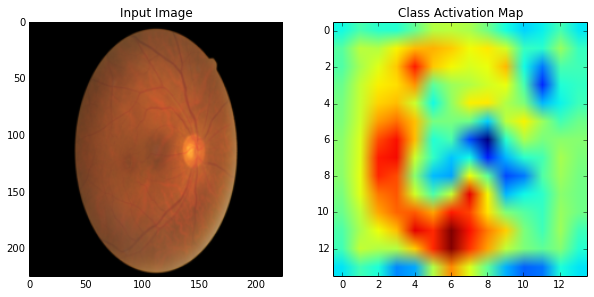

PREDICTED CLASS : 2  (2_glaucoma)
     TRUE CLASS : 2  (2_glaucoma)


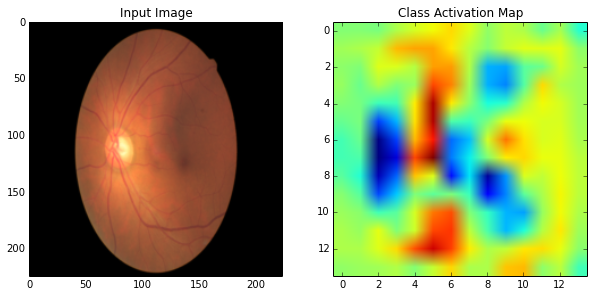

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 0  (1_normal)


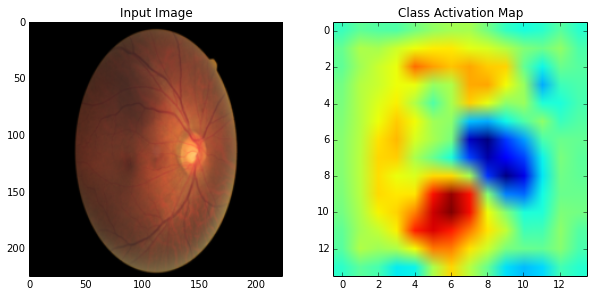

PREDICTED CLASS : 2  (2_glaucoma)
     TRUE CLASS : 2  (2_glaucoma)


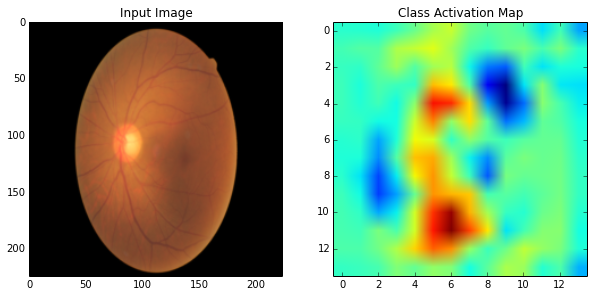

PREDICTED CLASS : 2  (2_glaucoma)
     TRUE CLASS : 2  (2_glaucoma)


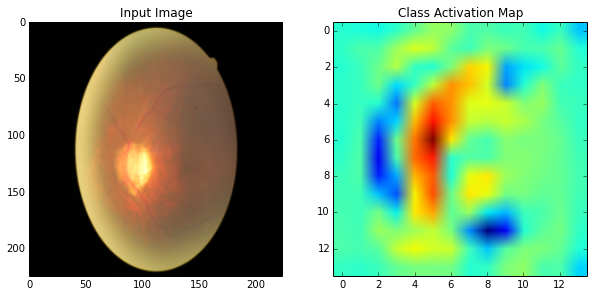

PREDICTED CLASS : 3  (3_retina_disease)
     TRUE CLASS : 0  (1_normal)


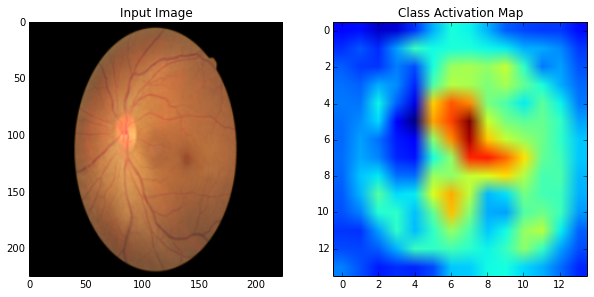

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 0  (1_normal)


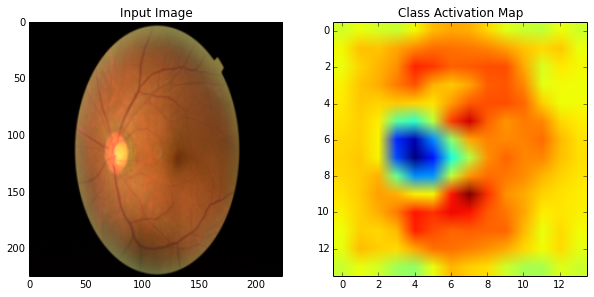

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 0  (1_normal)


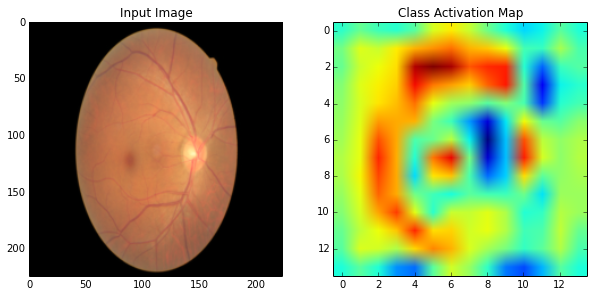

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 0  (1_normal)


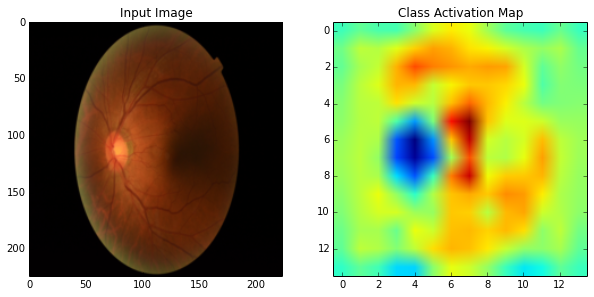

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 2  (2_glaucoma)


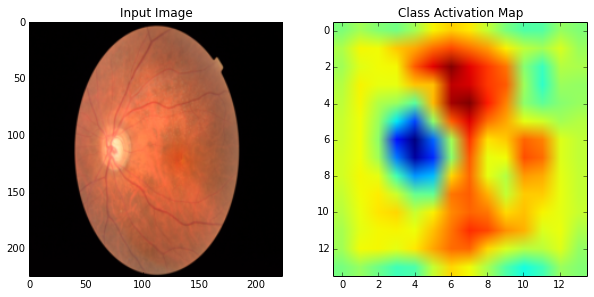

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 2  (2_glaucoma)


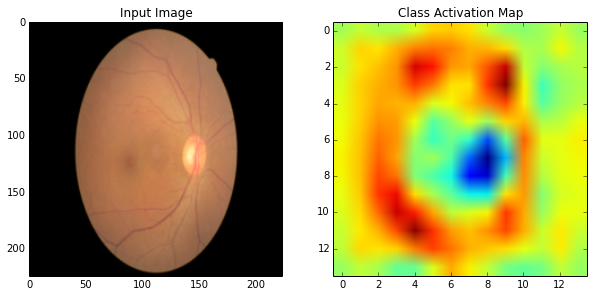

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 0  (1_normal)


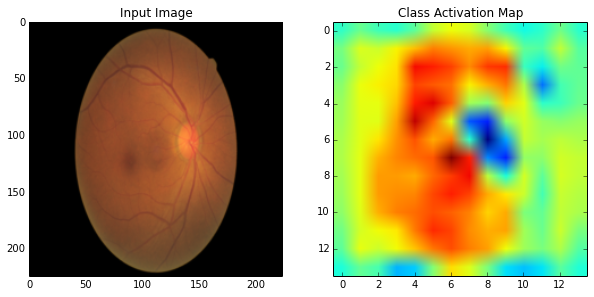

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 1  (2_cataract)


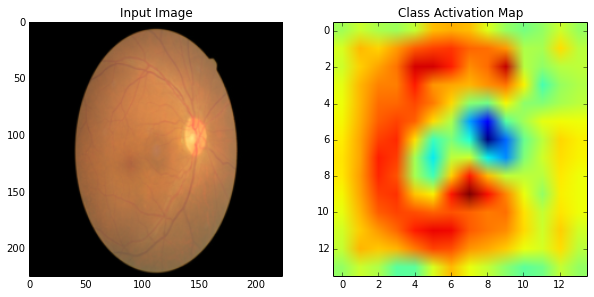

PREDICTED CLASS : 2  (2_glaucoma)
     TRUE CLASS : 2  (2_glaucoma)


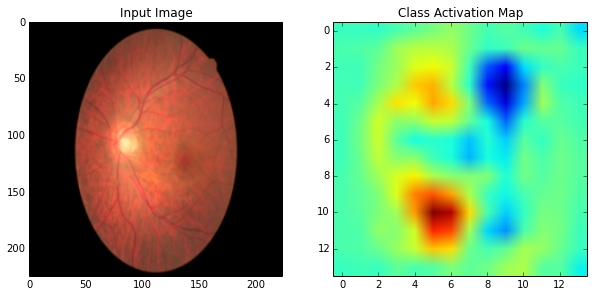

PREDICTED CLASS : 1  (2_cataract)
     TRUE CLASS : 1  (2_cataract)


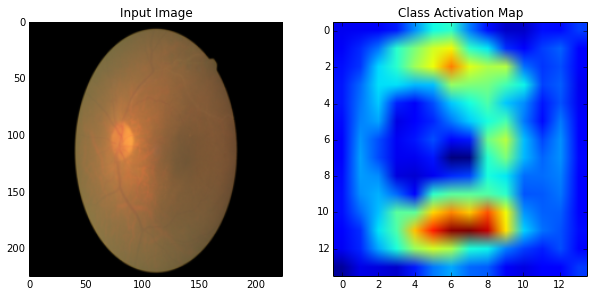

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 3  (3_retina_disease)


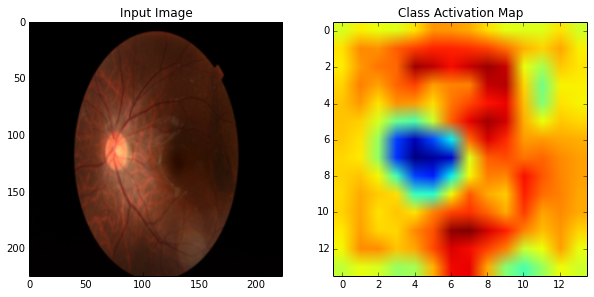

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 0  (1_normal)


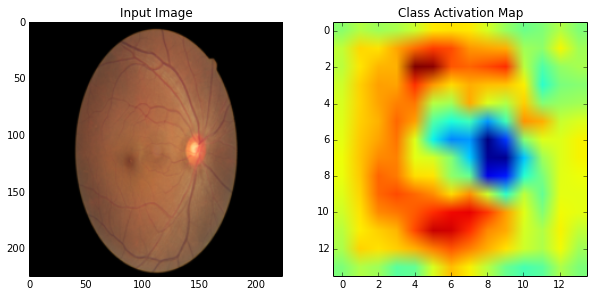

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 0  (1_normal)


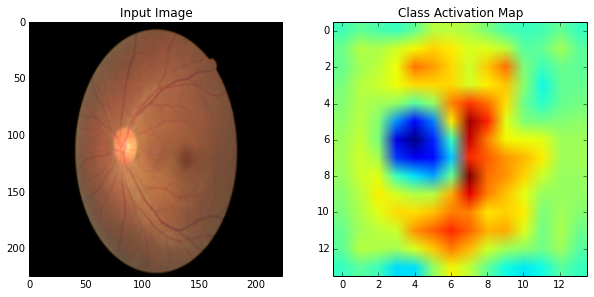

PREDICTED CLASS : 1  (2_cataract)
     TRUE CLASS : 1  (2_cataract)


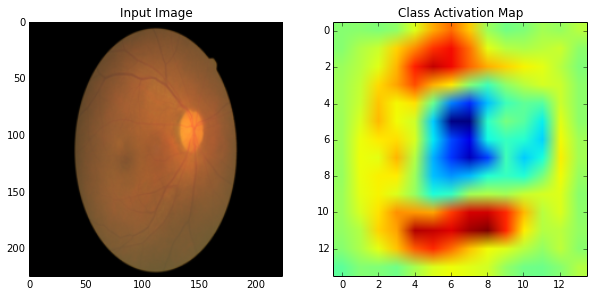

PREDICTED CLASS : 0  (1_normal)
     TRUE CLASS : 1  (2_cataract)


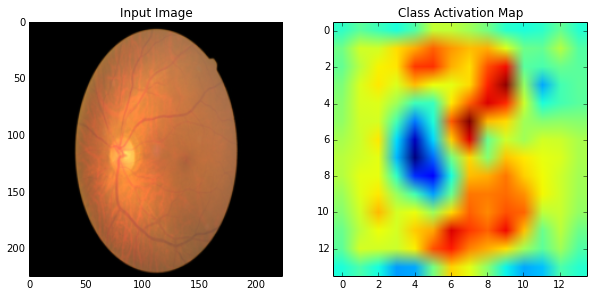

In [14]:
ntest = test_imgs_tensor.shape[0]
randidx = np.random.randint(ntest, size=20)
for idx in randidx:
    testimg = test_imgs_tensor[idx, :, :, :]
    testimg = testimg.reshape((-1,) + testimg.shape)
    testlabel = np.argmax(test_labels_tensor[idx, :])

    with tf.device(device_type):
        vgg, _, _ = vggnet(VGG_PATH, img_placeholder)
    cam_testfeat, cam_outval, cam_weights = sess.run([vgg['relu5_4'], pred, weights['out']],
                        feed_dict={img_placeholder: testimg, kr: 1.})
    predlabel = np.argmax(cam_outval)
    predweights = cam_weights[:, predlabel]
    camsum = np.zeros((14, 14))
    for i in xrange(512): 
        camsum = camsum + predweights[i] * cam_testfeat[0,:,:,i]
    camavg = camsum / 512.

    print "PREDICTED CLASS : %d  (%s)" % (predlabel, categories[predlabel])
    print "     TRUE CLASS : %d  (%s)" % (testlabel, categories[testlabel])
    # PLOT
    fig1 = plt.figure(figsize=(10, 6))
    ax1 = fig1.add_subplot(1,2,1)     
    ax1.imshow(testimg[0])
    ax1.set_title("Input Image")
    ax2 = fig1.add_subplot(1,2,2)     
    im2 = ax2.imshow(camavg, origin='upper')
    ax2.set_title("Class Activation Map")
    # plt.colorbar(im2, ax=ax2)
    plt.show()
